1. Implementation of SVD

   Target: Using SVD to analyze computer network traffic

Singular Value Decomposition from scratch:
    
    A = UEV^t
    

In [1]:
# import math
import numpy as np
import pandas as pd

# Functions

def mxMulti(A, B):
    """
    Function to multiply two matrices A and B

    """
    # Get dimensions
    m, n = A.shape
    m2, n2 = B.shape
    
    # Check if multiplication is possible
    if n != m2:
        raise ValueError(f"Cannot multiply: A is {m}×{n}, B is {m2}×{n2}. Middle dimensions must match!")
    
    # Create result matrix
    C = np.zeros((m, n2))
    
    # Multiply
    for i in range(m):
        for j in range(n2):
            value = 0
            for k in range(n):
                value += A[i, k] * B[k, j]
            C[i, j] = value
    
    return C

def vrppc(singulars):
    """
    this function analyze the amount of variance retained in principal component
    """

    s = len(singulars)

    sqval = []
    for i in range(s):
        sqval.append(singulars[i] ** 2) # square values

    # callculate the sum
    totalsum = 0
    for i in range(s):
        totalsum += sqval[i]

    # total variance
    totalv = 0
    for i in range(s):
        totalv += sqval[i]

    # variance per component 
    variancepp = []
    for i in range(s):
        variancepp.append(sqval[i] / totalv)

    # cummulative
    cumulativev = []
    csum = 0

    for i in range(s):
        csum = csum + float(variancepp[i])
        cumulativev.append(csum)

    return variancepp, cumulativev
        
# function to calculate AAT

def ata(matrixa):
    
    """
    Calculate AAT for Matrix A and return matrix B = AAT
    """
    
    # extract dimensions of the matrix; m - rows, n - cols
    m, n = matrixa.shape

    # create empty matrix for transpose with swapped dimensions, then loop reverse
    atranspose = np.zeros((n,m))

    for i in range(m):
        for x in range(n): 
            atranspose[x,i] = matrixa[i,x]
            
    print(matrixa)

    print(atranspose)

    # get dimension of the atranspose - reversed n with m as per transpose
    m2, n2 = atranspose.shape

    #create empty matrixb = A^T A
    matrixb = np.zeros((m2, n))

    for i in range(m2):
        for x in range(n):
            product = 0
            for y in range(m):
                product += atranspose[i,y] * matrixa[y,x]
            matrixb[i,x] = product
    
    return matrixb

def creprojectionM(V, k):
    """
    Create projection matrix using first k principal components.
  
    """
    n = V.shape[1]
    V_k = np.zeros((n, k))
    
    for i in range(n):
        for j in range(k):
            V_k[i, j] = V[i, j]
    
    return V_k


test value - left for troubleshooting pourposes:

In [2]:
# matrix = np.array([[1,0,1], [-2,1,0]])


Sample data set - packet capture


| No. | Time     | Source            | Destination       | Protocol | Length | Info                                                                                                                    |
|-----|----------|-------------------|-------------------|----------|--------|-------------------------------------------------------------------------------------------------------------------------|
| 1   | 0.000000 | 69.245.49.10      | 143.173.237.247   | TCP      | 1504   | 2082 > 1214 [ACK] Seq=1 Ack=1 Win=17188 Len=1460[Packet size limited during capture]                                   |
| 2   | 0.000011 | 236.179.225.218   | 241.46.188.127    | TCP      | 56     | 47302 > 80 [ACK] Seq=1 Ack=1 Win=17520 Len=0[Packet size limited during capture]                                       |
| 3   | 0.000025 | 3.3.241.136       | 252.224.52.109    | TCP      | 64     | 10646 > 1469 [PSH, ACK] Seq=1 Ack=1 Win=9660 Len=20[Packet size limited during capture]                                |
| 4   | 0.000039 | 3.3.241.136       | 252.224.52.109    | TCP      | 1424   | [TCP Out-Of-Order] 10646 > 1469 [ACK] Seq=4294965917 Ack=1 Win=9660 Len=1380                                           |
| 5   | 0.000044 | 3.3.241.136       | 252.224.52.109    | TCP      | 1135   | [TCP Out-Of-Order] 10646 > 1469 [ACK] Seq=4294964826 Ack=1 Win=9660 Len=1091                                           |
| 6   | 0.000047 | 238.201.77.212    | 115.224.122.122   | TCP      | 44     | 80 > 2436 [ACK] Seq=1 Ack=1 Win=8460 Len=0                                                                             |
| 7   | 0.000051 | 69.249.227.206    | 0.3.117.181       | TCP      | 44     | 4945 > 80 [ACK] Seq=1 Ack=1 Win=8760 Len=0                                                                             |
| 8   | 0.000083 | 236.179.225.214   | 241.46.188.127    | TCP      | 56     | 8266 > 80 [FIN, ACK] Seq=1 Ack=1 Win=17520 Len=0[Packet size limited during capture]                                   |
| 9   | 0.000085 | 236.179.225.218   | 241.46.188.127    | TCP      | 132    | [TCP Previous segment not captured] 47302 > 80 [PSH, ACK] Seq=594 Ack=1 Win=17520 Len=76[Packet size limited during capture] |
| 10  | 0.000122 | 69.110.16.40      | 241.84.136.53     | TCP      | 64     | 5762 > 80 [SYN] Seq=0 Win=65535 Len=0 MSS=1460[Packet size limited during capture]                                     |

In [4]:
import pandas as pd

df = pd.read_csv('oc48-mfn.dirA.20_v2_50000.csv', usecols=['Source', 'Destination', 'Protocol', 'Length'])

# encode labels to numbers using pandas 
df['Protocol'] = pd.factorize(df['Protocol'])[0]
df['Source'] = pd.factorize(df['Source'])[0]
df['Destination'] = pd.factorize(df['Destination'])[0]
df['Length'] = pd.factorize(df['Length'])[0]

# convert to numpy array for SVD
A = df.to_numpy()

print(A)

[[   0    0    0    0]
 [   1    1    0    1]
 [   2    2    0    2]
 ...
 [1351 8729    0    3]
 [ 386  588    0  157]
 [2542 8730    0    2]]


a) Compute the singular values EpsilonI; finding the square roots of the Eisgenvalues of the matrix A^T A

In [5]:
# calling the function to obtain matrixb = A^TA
B = ata(A)

print(B)    

[[   0    0    0    0]
 [   1    1    0    1]
 [   2    2    0    2]
 ...
 [1351 8729    0    3]
 [ 386  588    0  157]
 [2542 8730    0    2]]
[[0.000e+00 1.000e+00 2.000e+00 ... 1.351e+03 3.860e+02 2.542e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 8.729e+03 5.880e+02 8.730e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 2.000e+00 ... 3.000e+00 1.570e+02 2.000e+00]]
[[3.96792267e+11 3.17491772e+11 1.21855040e+08 1.37114989e+10]
 [3.17491772e+11 5.30605651e+11 1.37634520e+08 1.64841084e+10]
 [1.21855040e+08 1.37634520e+08 1.15409900e+06 1.13637000e+07]
 [1.37114989e+10 1.64841084e+10 1.13637000e+07 3.59027089e+09]]


b) Find the right singular vectors V by finding an orthonormal set of eigenvectors of A^T A

In [6]:
# finding eigenvalues and eigenvectors
eigenval, eigenvec = np.linalg.eigh(B)

# print(eigenval)

# print(eigenvec)

# sort both eigenvalues and eigenvectors
idx = eigenval.argsort()[::-1]  # Descending order
eigenval = eigenval[idx]
eigenvec = eigenvec[:, idx]

# clean values - negative value becomes 0
eigenval = np.maximum(eigenval, 0)

print(eigenval)

print(eigenvec)

# assining values to V
V = eigenvec

[7.88749431e+11 1.39234477e+11 3.00433787e+09 1.09742487e+06]
[[-6.29771380e-01 -7.76555464e-01  1.86975351e-02  1.51661196e-04]
 [-7.76300767e-01  6.30045933e-01  1.99807601e-02  1.02975561e-04]
 [-2.33150156e-04 -5.69768512e-05 -2.10809210e-03 -9.99997749e-01]
 [-2.72960430e-02 -1.93148388e-03 -9.99623293e-01  2.11377685e-03]]



c) Compute the elements Ui of U using Ui = (1/EpsilonI)AVi


In [120]:
# Compute singular values
singularval = np.sqrt(eigenval)

print(singularval)

ma, na = A.shape

k = min(ma, na) # number of components

print(f"Number of singular values: {k}")

# compute U - create matrix of Zeros
U = np.zeros((ma, ma))

# loop computes each column of the U matrix, skips values that cannot be devided by zero
for i in range(k):
    if singularval[i] > 1e-10:
        U[:, i] = (A @ eigenvec[:, i]) / singularval[i]

print(U)


[888115.6630262  373141.36356839  54811.84063673   1047.5804854 ]
Number of singular values: 4
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.61394315e-06 -3.97814419e-07 -1.75317046e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.22788630e-06 -7.95628837e-07 -3.50634092e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-8.58810708e-03  1.19272189e-02  3.58815820e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.92511732e-04  1.88704238e-04 -2.51724664e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.43350003e-03  9.45028745e-03  4.01303662e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Create Sigma

In [121]:
# there is a problem when getting sigma, so need to normalize per number of U columns, initially i was assigning ma x ma not k x k
Uk = U[:, :k]
sigma = np.zeros((k,k)) # square diagonal

for i in range(k):
    sigma[i,i] = singularval[i]

print(sigma)

# fix sigma 

[[888115.6630262       0.              0.              0.        ]
 [     0.         373141.36356839      0.              0.        ]
 [     0.              0.          54811.84063673      0.        ]
 [     0.              0.              0.           1047.5804854 ]]


In [122]:
# V transpose - first create empty matrix
me, ne = eigenvec.shape
vt = np.zeros((ne,me))

for i in range(me):
    for j in range(ne):
        vt[j,i] = eigenvec[i,j]

print(vt)
print(vt.shape)
print(eigenvec)
print(eigenvec.shape)

[[-6.29771380e-01 -7.76300767e-01 -2.33150156e-04 -2.72960430e-02]
 [-7.76555464e-01  6.30045933e-01 -5.69768512e-05 -1.93148388e-03]
 [ 1.86975351e-02  1.99807601e-02 -2.10809210e-03 -9.99623293e-01]
 [ 1.51661196e-04  1.02975561e-04 -9.99997749e-01  2.11377685e-03]]
(4, 4)
[[-6.29771380e-01 -7.76555464e-01  1.86975351e-02  1.51661196e-04]
 [-7.76300767e-01  6.30045933e-01  1.99807601e-02  1.02975561e-04]
 [-2.33150156e-04 -5.69768512e-05 -2.10809210e-03 -9.99997749e-01]
 [-2.72960430e-02 -1.93148388e-03 -9.99623293e-01  2.11377685e-03]]
(4, 4)


Calculate the end product:

In [123]:
# multiplication in two steps:
mu, nu = Uk.shape
ms, ns = sigma.shape
uxsigma = np.zeros((mu,ns)) #result of the first multiplication

# first multiplication
for i in range(mu):
    for j in range(ns):
        value = 0
        for k in range(nu):
            value += Uk[i, k] * sigma[k,j]
        uxsigma[i,j] = value

# second multiplication
mus, nus = uxsigma.shape
mvt, nvt = vt.shape
uxsigmaxvt = np.zeros((mus, nvt)) # end result

for i in range(mus):
    for j in range(nvt):
        value = 0
        for k in range(mvt):
            value += uxsigma[i,k] * vt[k,j]
        uxsigmaxvt[i,j] = value

print(uxsigma)

print(uxsigmaxvt)

step1=mxMulti(Uk,sigma)

print(step1)

step2=mxMulti(step1, vt)

print(step2)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.43336819e+00 -1.48441015e-01 -9.60944997e-01  2.36841361e-03]
 [-2.86673638e+00 -2.96882029e-01 -1.92188999e+00  4.73682722e-03]
 ...
 [-7.62723242e+03  4.45053872e+03  1.96673555e+02  1.11010928e+00]
 [-7.03842082e+02  7.04133566e+01 -1.37974921e+02  4.50953817e-01]
 [-8.37803914e+03  3.52629314e+03  2.19961924e+02  1.28872696e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  3.77302356e-17  1.00000000e+00]
 [ 2.00000000e+00  2.00000000e+00  7.54604712e-17  2.00000000e+00]
 ...
 [ 1.35100000e+03  8.72900000e+03 -5.10702591e-15  3.00000000e+00]
 [ 3.86000000e+02  5.88000000e+02  5.49560397e-15  1.57000000e+02]
 [ 2.54200000e+03  8.73000000e+03 -6.21724894e-15  2.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.43336819e+00 -1.48441015e-01 -9.60944997e-01  2.36841361e-03]
 [-2.86673638e+00 -2.96882029e-01 -1.92188999e+00 

 Analyse the amount of variance retained per principal componnent:

In [132]:
# using function
varianceppc, cvar = vrppc(singularval)

print(varianceppc)

print("Variance retained per principal component:")
for i in range(len(varianceppc)):
    print(f"PC{i+1}: {varianceppc[i]*100:.2f}%")

print("\nCumulative variance retained:")
for i in range(len(cvar)):
    print(f"First {i+1} PC(s): {cvar[i]*100:.2f}%")
    


[np.float64(0.8472163902730906), np.float64(0.1495553930774803), np.float64(0.0032270378766739664), np.float64(1.1787727551774646e-06)]
Variance retained per principal component:
PC1: 84.72%
PC2: 14.96%
PC3: 0.32%
PC4: 0.00%

Cumulative variance retained:
First 1 PC(s): 84.72%
First 2 PC(s): 99.68%
First 3 PC(s): 100.00%
First 4 PC(s): 100.00%


Create projection Matrix:

In [133]:

# find optimal k
threshold = 0.95 # 
k = len(cvar)  # Default to all components

for i in range(len(cvar)):
      if cvar[i] >= threshold:
            k = i + 1
            break
          
print(k)

vk = creprojectionM(eigenvec, k)

print(vk)



2
[[-6.29771380e-01 -7.76555464e-01]
 [-7.76300767e-01  6.30045933e-01]
 [-2.33150156e-04 -5.69768512e-05]
 [-2.72960430e-02 -1.93148388e-03]]


Project data into principal components:


In [134]:
# using function 

projection = mxMulti(A, vk)

print(projection)

print("eigenvec shape:", eigenvec.shape)
print("A shape:", A.shape)




[[ 0.00000000e+00  0.00000000e+00]
 [-1.43336819e+00 -1.48441015e-01]
 [-2.86673638e+00 -2.96882029e-01]
 ...
 [-7.62723242e+03  4.45053872e+03]
 [-7.03842082e+02  7.04133566e+01]
 [-8.37803914e+03  3.52629314e+03]]
eigenvec shape: (4, 4)
A shape: (50000, 4)


plot diagram:

[[ 0.00000000e+00  0.00000000e+00]
 [-1.43336819e+00 -1.48441015e-01]
 [-2.86673638e+00 -2.96882029e-01]
 ...
 [-7.62723242e+03  4.45053872e+03]
 [-7.03842082e+02  7.04133566e+01]
 [-8.37803914e+03  3.52629314e+03]]
project2d shape: (50000, 2)
v2d shape: (4, 2)


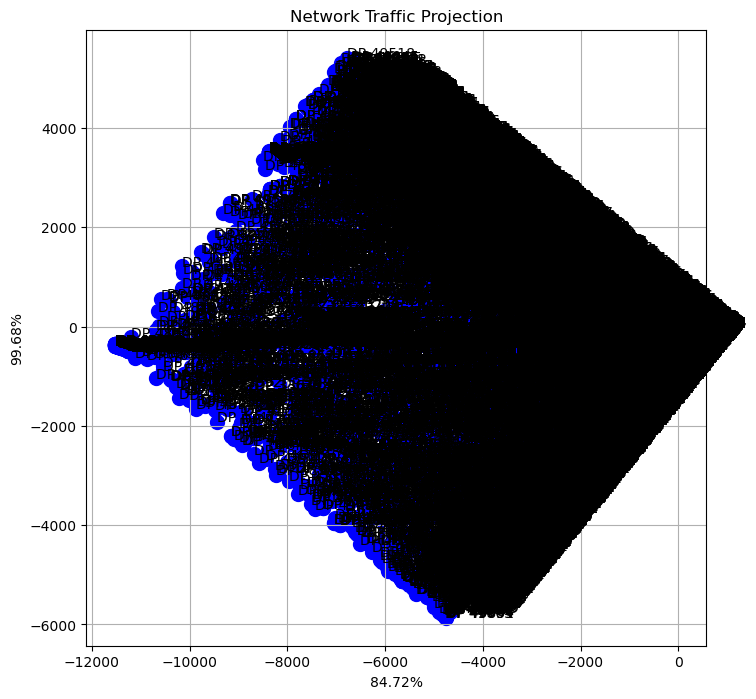

In [137]:
import matplotlib.pyplot as plt

# projection for 2d

V2d = creprojectionM(eigenvec, 2)
project2d = mxMulti(A, V2d)

print(project2d)

print("project2d shape:", project2d.shape)
print("v2d shape:", V2d.shape)

pc1 = f"{cvar[0]*100:.2f}%"
pc2 = f"{cvar[1]*100:.2f}%"
plt.figure(figsize=(8, 8))
plt.scatter(project2d[:, 0], project2d[:, 1], s=100, c='blue')

for i in range(len(project2d)):
    plt.annotate(f'DP {i}', (project2d[i, 0], project2d[i, 1]))

plt.xlabel(pc1)
plt.ylabel(pc2)
plt.title('Network Traffic Projection')
plt.grid(True)
plt.show()